In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.cbook import boxplot_stats
from pathlib import Path
import numpy as np

/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_13882/976477465.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# colourblind-friendly palette from colour universal design (CUD)
# https://jfly.uni-koeln.de/color/
# https://nanx.me/oneclust/reference/cud.html
named_colors = {
    "black": "#000000",
    "orange": "#e69f00",
    "skyblue": "#56b4e9",
    "bluish green": "#009e73",
    "yellow": "#f0e442",
    "blue": "#0072b2",
    "vermilion": "#d55e00",
    "reddish purple": "#cc79a7",
}
cud_palette = list(named_colors.values())
sns.set_theme(style="whitegrid")

def cud(n: int = len(cud_palette), start: int = 0) -> list[str]:
    remainder = cud_palette[:start]
    palette = cud_palette[start:] + remainder
    return palette[:n]

In [3]:
frames = []
COV = 100
for p in Path("../results/assess/mutref").rglob("*.precision-recall.tsv"):
    df = pd.read_csv(p, sep="\t")
    df["sample"] = p.parent.name
    if "without_repetitive_regions" in p.name:
        continue
    if "illumina" in str(p):
        df["caller"] = "illumina"
        df["depth"] = "illumina"
        df["mode"] = "simplex"
        df["version"] = "illumina"
        df["model"] = "illumina"
    else:
        df["caller"] = p.parts[-7]
        depth = int(p.parts[-6][:-1])
        if depth != COV:
            continue
        df["depth"] = p.parts[-6]
        df["mode"] = p.parts[-5]
        df["version"] = p.parts[-4]
        df["model"] = p.parts[-3].split("_")[-1].split("@")[0]
    frames.append(df)
    # duplicate Illumina as duplex also
    if "illumina" in str(p):
        df2 = df.copy()
        df2["caller"] = "illumina"
        df2["depth"] = "illumina"
        df2["mode"] = "duplex"
        df2["version"] = "illumina"
        df2["model"] = "illumina"
        frames.append(df2)

In [4]:
pr_df = pd.concat(frames)
pr_df.reset_index(inplace=True)
pr_df.head()

,index,VAR_TYPE,MIN_QUAL,PREC,RECALL,F1_SCORE,F1_QSCORE,TRUTH_TOTAL,TRUTH_TP,TRUTH_FN,QUERY_TOTAL,QUERY_TP,QUERY_FP,sample,caller,depth,mode,version,model
0,0,SNP,0,0.627673,0.921503,0.746723,5.964046,2102,1937,165,3086,1937,1149,AMtb_1__202402,nanocaller,100x,duplex,v4.3.0,hac
1,1,SNP,1,0.627673,0.921503,0.746723,5.964046,2102,1937,165,3086,1937,1149,AMtb_1__202402,nanocaller,100x,duplex,v4.3.0,hac
2,2,SNP,2,0.627673,0.921503,0.746723,5.964046,2102,1937,165,3086,1937,1149,AMtb_1__202402,nanocaller,100x,duplex,v4.3.0,hac
3,3,SNP,3,0.627673,0.921503,0.746723,5.964046,2102,1937,165,3086,1937,1149,AMtb_1__202402,nanocaller,100x,duplex,v4.3.0,hac
4,4,SNP,4,0.627673,0.921503,0.746723,5.964046,2102,1937,165,3086,1937,1149,AMtb_1__202402,nanocaller,100x,duplex,v4.3.0,hac


In [5]:
def annotate_axes(ax, text, fontsize=18):
    ax.text(0.5, 0.5, text, transform=ax.transAxes,
            ha="center", va="center", fontsize=fontsize, color="darkgrey")

In [6]:
samples = set(pr_df["sample"])
metrics = []
for vartype in ("SNP", "INDEL"):
    for mode in ("simplex", "duplex"):
        for caller in pr_df["caller"].unique():
            for model in ("sup", "hac", "fast"):
                if caller == "longshot" and vartype == "INDEL":
                    continue
                print(caller)
                if caller != "illumina":
                    data = pr_df.query(f"caller == '{caller}' and VAR_TYPE == '{vartype}' and mode == '{mode}' and model == '{model}'")
                else:
                    data = pr_df.query(f"caller == '{caller}' and VAR_TYPE == '{vartype}' and mode == '{mode}' and model == 'illumina'")
                for q in sorted(set(data["MIN_QUAL"])):
                    # we subsample freebays to avoid overplotting due to the wide range of MIN_QUAL values
                    # if caller in ("freebays") and q % 10 != 0:
                        # continue
                    # check if every sample has this MIN_QUAL
                    subdf = data.query(f"MIN_QUAL == {q}")
                    if set(subdf["sample"]) == samples:
                        tps = subdf["TRUTH_TP"].sum()
                        fps = subdf["QUERY_FP"].sum()
                        fns = subdf["TRUTH_FN"].sum()
                        precision = tps / (tps + fps)
                        recall = tps / (tps + fns)
                        f1 = 2 * (precision * recall) / (precision + recall)
                        metrics.append((caller, q, precision, recall, f1, vartype, mode, model))



nanocaller
nanocaller
nanocaller
clair3
clair3
clair3
bcftools
bcftools
bcftools
longshot
longshot
longshot
illumina
illumina
illumina
deepvariant
deepvariant
deepvariant
freebayes
freebayes
freebayes
nanocaller
nanocaller
nanocaller
clair3
clair3
clair3
bcftools
bcftools
bcftools
longshot
longshot
longshot
illumina
illumina
illumina
deepvariant
deepvariant
deepvariant
freebayes
freebayes
freebayes
nanocaller
nanocaller
nanocaller
clair3


/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_13882/1781762619.py:24: RuntimeWarning: invalid value encountered in scalar divide
  precision = tps / (tps + fps)


clair3
clair3
bcftools
bcftools
bcftools
illumina
illumina
illumina
deepvariant
deepvariant
deepvariant
freebayes
freebayes
freebayes
nanocaller
nanocaller
nanocaller
clair3
clair3
clair3
bcftools
bcftools
bcftools
illumina
illumina
illumina
deepvariant
deepvariant
deepvariant
freebayes
freebayes
freebayes


In [7]:
aggdf = pd.DataFrame(metrics, columns=["caller", "QUAL", "precision", "recall", "f1", "vartype", "mode", "model"])

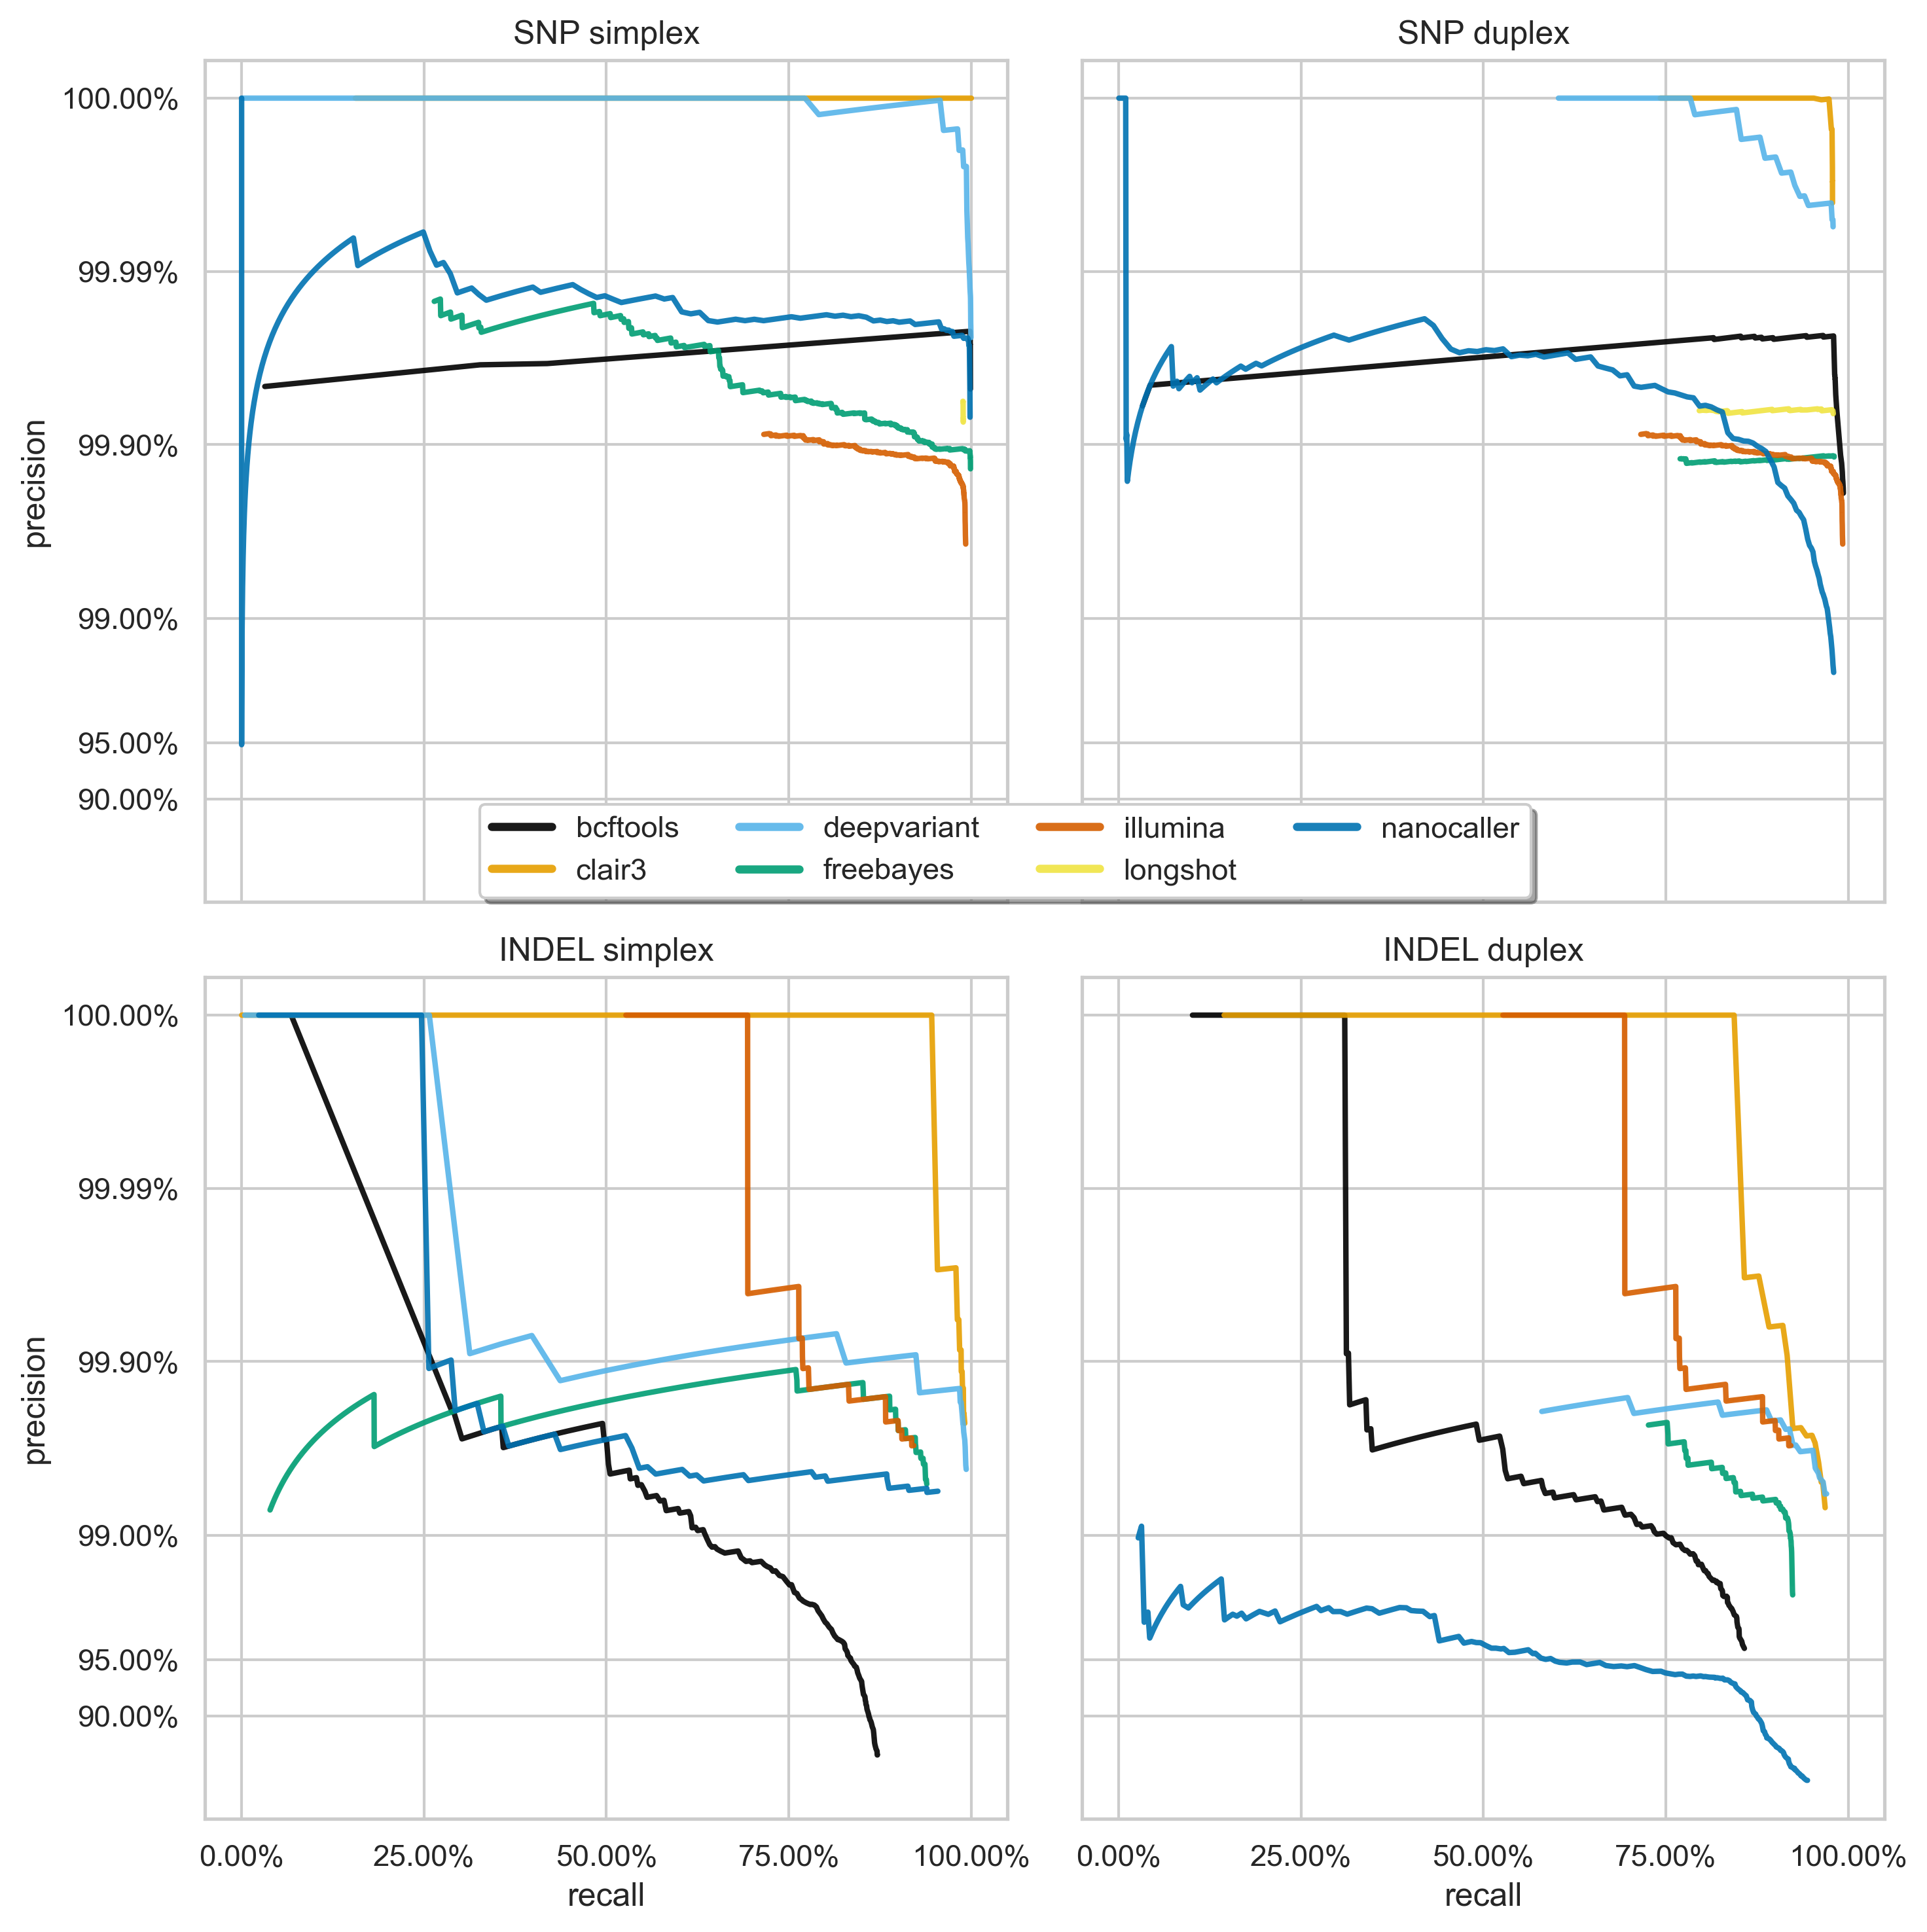

In [86]:
vartypes = ["SNP", "INDEL"]
modes = ["simplex", "duplex"]
model = "sup"
fig, axes = plt.subplots(
    ncols=len(vartypes),
    nrows=len(modes),
    figsize=(10, 10),
    dpi=300,
    sharex=True,
    sharey=True,
)
x = "recall"
y = "precision"
hue = "caller"
style = "model"

hue_order = sorted(set(aggdf[hue]))
# move illumina to end
hue_order.remove("illumina")
hue_order.append("illumina")
# map each caller in hue order to a colour in cud
pal = {c: cud()[i] for i, c in enumerate(hue_order)}

i = 0
legend = True
for vartype in vartypes:
    for mode in modes:
        ax = axes.flatten()[i]
        data = aggdf.query("vartype == @vartype and mode == @mode and model == @model")
        cap = 0.99999
        data.loc[:, y] = data[y].apply(lambda v: cap if v > cap else v)

        if vartype == "INDEL":
            data = data.query("caller != 'longshot'")

        sns.lineplot(
            data=data,
            x=x,
            y=y,
            hue=hue,
            hue_order=sorted(pal),
            # style=style,
            ax=ax,
            palette=pal,
            alpha=0.9,
            linewidth=2,
            legend=legend,
        )

        if legend:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend().remove()
            legend = False

        ax.set_yscale("logit", nonpositive="clip")
        yticks = [0.9, 0.95, 0.99, 0.999, 0.9999, cap]
        yticklabels = [f"{yval:.2%}" for yval in yticks]
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)

        xticks = [0, 0.25, 0.5, 0.75, 1.0]
        xticklabels = [f"{xval:.2%}" for xval in xticks]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
        ax.set_title(f"{vartype} {mode}")
        i += 1
# make legend lines thicker
for h in handles:
    h.set_linewidth(3)
# for line in ax.get_legend().get_lines():
#     line.set_linewidth(3)

plt.tight_layout()
leg_cols = math.ceil((len(aggdf[hue].unique())+1)/2)
fig.legend(
    handles=handles,
    labels=labels,
    loc="upper center",
    bbox_to_anchor=(0.52, 0.59),
    ncol=leg_cols,
    title="",
    framealpha=1.0,
    fancybox=True,
    shadow=True,
)

In [64]:
fb = aggdf.query("caller == 'freebayes' and vartype == 'SNP' and mode == 'simplex' and model == 'sup'")

In [65]:
fb

,caller,QUAL,precision,recall,f1,vartype,mode,model
11728,freebayes,0,0.997211,0.985222,0.991180,SNP,simplex,sup
11729,freebayes,1,0.997303,0.985221,0.991225,SNP,simplex,sup
11730,freebayes,2,0.997369,0.985218,0.991256,SNP,simplex,sup
11731,freebayes,3,0.997435,0.985216,0.991288,SNP,simplex,sup
11732,freebayes,4,0.997494,0.985208,0.991313,SNP,simplex,sup
...,...,...,...,...,...,...,...,...
15211,freebayes,3483,0.999852,0.220646,0.361514,SNP,simplex,sup
15212,freebayes,3484,0.999852,0.220243,0.360973,SNP,simplex,sup
15213,freebayes,3485,0.999852,0.219873,0.360476,SNP,simplex,sup
15214,freebayes,3486,0.999852,0.219434,0.359885,SNP,simplex,sup


In [66]:
qr = fb[["QUAL", "recall"]]

In [68]:
# convert qr to list of tuples
qr = [tuple(x) for x in qr.to_numpy()]

In [70]:
prev_qual, prev_rec = qr[0]
for qual, rec in qr[1:]:
    if rec > prev_rec:
        print(f"QUAL: {prev_qual} -> {qual}, recall: {prev_rec:.2%} -> {rec:.2%}")
        break
    prev_qual, prev_rec = qual, rec

QUAL: 393.0 -> 394.0, recall: 63.51% -> 63.75%


In [79]:
samples = set(pr_df["sample"])
for s in samples:
    d = pr_df.query("sample == @s and caller == 'freebayes' and VAR_TYPE == 'SNP' and mode == 'simplex' and model == 'sup'")
    qr = [tuple(x) for x in d[["MIN_QUAL", "RECALL"]].to_numpy()]
    prev_qual, prev_rec = qr[0]
    for qual, rec in qr[1:]:
        if rec > prev_rec:
            print(f"Sample: {s}, QUAL: {prev_qual} -> {qual}, recall: {prev_rec:.2%} -> {rec:.2%}")
            break
        prev_qual, prev_rec = qual, rec

In [73]:
pr_df

,index,VAR_TYPE,MIN_QUAL,PREC,RECALL,F1_SCORE,F1_QSCORE,TRUTH_TOTAL,TRUTH_TP,TRUTH_FN,QUERY_TOTAL,QUERY_TP,QUERY_FP,sample,caller,depth,mode,version,model
0,0,SNP,0,0.627673,0.921503,0.746723,5.964046,2102,1937,165,3086,1937,1149,AMtb_1__202402,nanocaller,10x,duplex,v4.3.0,hac
1,1,SNP,1,0.627673,0.921503,0.746723,5.964046,2102,1937,165,3086,1937,1149,AMtb_1__202402,nanocaller,10x,duplex,v4.3.0,hac
2,2,SNP,2,0.627673,0.921503,0.746723,5.964046,2102,1937,165,3086,1937,1149,AMtb_1__202402,nanocaller,10x,duplex,v4.3.0,hac
3,3,SNP,3,0.627673,0.921503,0.746723,5.964046,2102,1937,165,3086,1937,1149,AMtb_1__202402,nanocaller,10x,duplex,v4.3.0,hac
4,4,SNP,4,0.627673,0.921503,0.746723,5.964046,2102,1937,165,3086,1937,1149,AMtb_1__202402,nanocaller,10x,duplex,v4.3.0,hac
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6109375,4915,ALL,1225,1.000000,0.000017,0.000034,0.000149,58471,1,58470,1,1,0,ATCC_17802__202309,freebayes,25x,simplex,v4.3.0,fast
6109376,4916,ALL,1226,1.000000,0.000017,0.000034,0.000149,58471,1,58470,1,1,0,ATCC_17802__202309,freebayes,25x,simplex,v4.3.0,fast
6109377,4917,ALL,1227,1.000000,0.000017,0.000034,0.000149,58471,1,58470,1,1,0,ATCC_17802__202309,freebayes,25x,simplex,v4.3.0,fast
6109378,4918,ALL,1228,1.000000,0.000017,0.000034,0.000149,58471,1,58470,1,1,0,ATCC_17802__202309,freebayes,25x,simplex,v4.3.0,fast


In [76]:
d.query("763 < MIN_QUAL < 771")

,index,VAR_TYPE,MIN_QUAL,PREC,RECALL,F1_SCORE,F1_QSCORE,TRUTH_TOTAL,TRUTH_TP,TRUTH_FN,QUERY_TOTAL,QUERY_TP,QUERY_FP,sample,caller,depth,mode,version,model
3429452,764,SNP,764,1.000000,0.000118,0.000236,0.001025,16953,2,16951,2,2,0,ATCC_35897__202309,freebayes,10x,simplex,v4.3.0,sup
3429453,765,SNP,765,1.000000,0.000118,0.000236,0.001025,16953,2,16951,2,2,0,ATCC_35897__202309,freebayes,10x,simplex,v4.3.0,sup
3429454,766,SNP,766,1.000000,0.000059,0.000118,0.000512,16953,1,16952,1,1,0,ATCC_35897__202309,freebayes,10x,simplex,v4.3.0,sup
3429455,767,SNP,767,1.000000,0.000059,0.000118,0.000512,16953,1,16952,1,1,0,ATCC_35897__202309,freebayes,10x,simplex,v4.3.0,sup
3997736,764,SNP,764,0.998345,0.996225,0.997284,25.660694,16953,16889,64,16922,16894,28,ATCC_35897__202309,freebayes,50x,simplex,v4.3.0,sup
3997737,765,SNP,765,0.998345,0.996225,0.997284,25.660694,16953,16889,64,16922,16894,28,ATCC_35897__202309,freebayes,50x,simplex,v4.3.0,sup
3997738,766,SNP,766,0.998345,0.996225,0.997284,25.660694,16953,16889,64,16922,16894,28,ATCC_35897__202309,freebayes,50x,simplex,v4.3.0,sup
3997739,767,SNP,767,0.998345,0.996048,0.997195,25.520773,16953,16886,67,16917,16889,28,ATCC_35897__202309,freebayes,50x,simplex,v4.3.0,sup
3997740,768,SNP,768,0.998345,0.996048,0.997195,25.520773,16953,16886,67,16917,16889,28,ATCC_35897__202309,freebayes,50x,simplex,v4.3.0,sup
3997741,769,SNP,769,0.998345,0.995989,0.997165,25.475054,16953,16885,68,16916,16888,28,ATCC_35897__202309,freebayes,50x,simplex,v4.3.0,sup


In [21]:
dataix = aggdf.groupby(["vartype", "mode", "model", "caller"])["f1"].idxmax()
data = aggdf.iloc[dataix]
data.to_csv("aggdf.csv", index=False)

In [13]:
aggdf

,caller,QUAL,precision,recall,f1,vartype,mode,model
0,nanocaller,0,0.999305,0.998228,0.998766,SNP,simplex,sup
1,nanocaller,1,0.999305,0.998228,0.998766,SNP,simplex,sup
2,nanocaller,2,0.999305,0.998228,0.998766,SNP,simplex,sup
3,nanocaller,3,0.999305,0.998228,0.998766,SNP,simplex,sup
4,nanocaller,4,0.999305,0.998228,0.998766,SNP,simplex,sup
...,...,...,...,...,...,...,...,...
60259,freebayes,278,0.943103,0.615991,0.745232,INDEL,duplex,fast
60260,freebayes,279,0.943103,0.615991,0.745232,INDEL,duplex,fast
60261,freebayes,280,0.943364,0.614302,0.744075,INDEL,duplex,fast
60262,freebayes,281,0.943339,0.614020,0.743861,INDEL,duplex,fast
